[![Ouvrir sur Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/SkatAI/deeplearning/blob/master/notebooks/transfer_learning_hands_on_claude_flowers.ipynb)

# Transfer Learning — Atelier pratique

**Deep Learning par la pratique — Alexis Perrier**

---

## Objectifs de cet atelier

1. **Comprendre le Transfer Learning** : pourquoi on ne part jamais de zéro en deep learning
2. **Travailler avec l'IA** : utiliser Gemini pour générer, lire et comprendre du code

## Comment utiliser ce notebook

- Les cellules avec du code pré-écrit : **lisez, exécutez, observez**
- Les cellules marquées 🤖 **GEMINI** : demandez à Gemini de générer le code, puis lisez-le et demandez-lui de vous l'expliquer
- Les cellules marquées ❓ **QUESTION** : répondez en observant les résultats

**Utiliser l'IA pour coder n'est pas tricher — c'est la méthode de travail.**
Votre valeur n'est pas de taper du code, c'est de savoir quoi demander, comprendre ce qu'on vous donne, et juger si le résultat est bon.

---

## Étape 0 — Setup et exploration des données

On travaille avec le dataset **tf_flowers** : des photos de 5 types de fleurs.
Notre objectif : construire un modèle qui les distingue.

Les 5 classes :
- 🌼 Daisy (pâquerette)
- 🌷 Tulip (tulipe)
- 🌹 Rose
- 🌻 Sunflower (tournesol)
- 🌸 Dandelion (pissenlit)

### 0.1 — Installer et importer les librairies

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU disponible: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.19.0
GPU disponible: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### 0.2 — Télécharger le dataset

Le dataset tf_flowers contient 3 670 images de fleurs réparties en 5 catégories.
On le charge directement depuis TensorFlow Datasets.

In [ ]:
# Charger le dataset avec les informations
(train_ds, val_ds), info = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:]'],  # 80% train, 20% validation
    as_supervised=True,                     # retourne (image, label)
    with_info=True
)

# Les noms des classes
class_names = info.features['label'].names
num_classes = len(class_names)

print(f"Classes : {class_names}")
print(f"Nombre de classes : {num_classes}")
print(f"Nombre total d'images : {info.splits['train'].num_examples}")

### 0.3 — Préparer les images

Les images du dataset ont des tailles différentes. On les redimensionne toutes à 160x160 pixels et on les regroupe en lots (batches) de 32.

In [3]:
IMG_SIZE = (160, 160)
BATCH_SIZE = 32

def preprocess(image, label):
    """Redimensionne l'image à 160x160."""
    image = tf.image.resize(image, IMG_SIZE)
    return image, label

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = (
    train_ds
    .map(preprocess, num_parallel_calls=AUTOTUNE)
    .shuffle(1000)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

val_dataset = (
    val_ds
    .map(preprocess, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

print("Datasets prêts !")

Datasets prêts !


### 🤖 GEMINI — Visualiser les données

Demandez à Gemini :

> *"Génère du code pour afficher une grille de 12 images du dataset `train_dataset` avec le nom de la fleur en titre. Les noms des classes sont dans la liste `class_names`. Utilise matplotlib avec une grille 3x4."*

Ensuite, demandez-lui :

> *"Explique-moi ce que fait chaque ligne de ce code."*

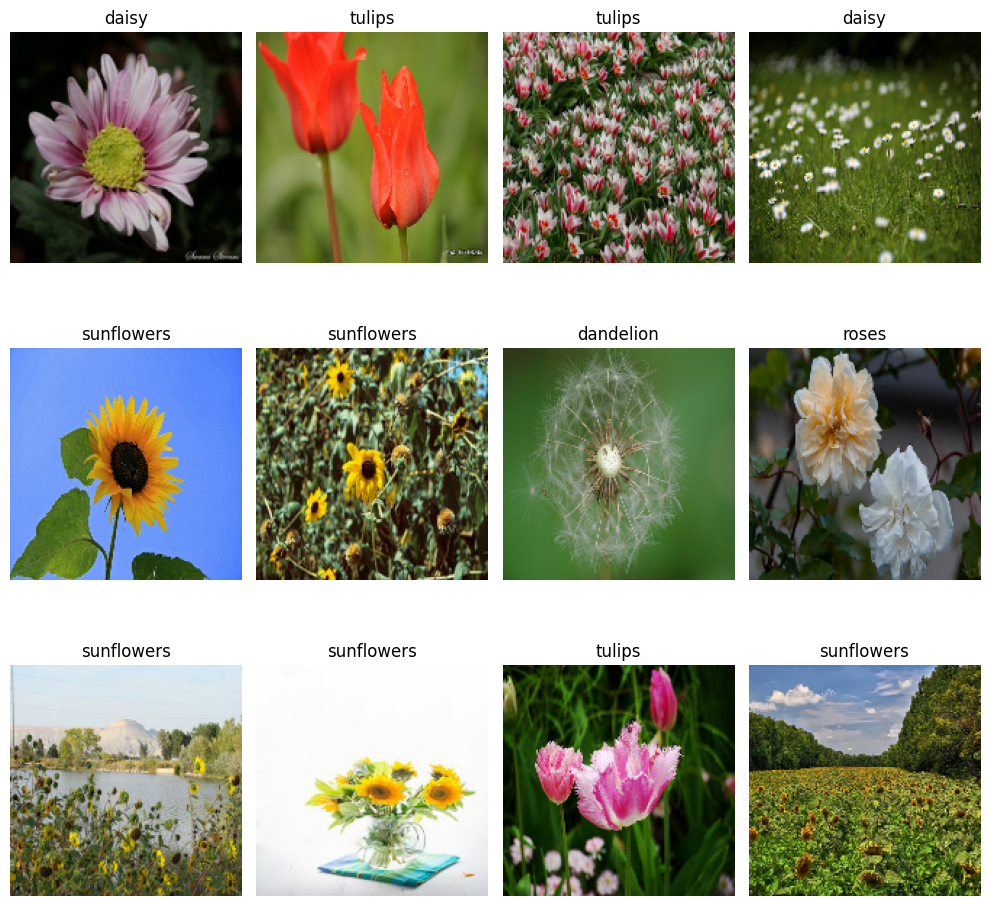

In [4]:
# VOTRE CODE GÉNÉRÉ PAR GEMINI ICI
plt.figure(figsize=(10, 10)) #crée une nouvelle figure Matplotlib et spécifie sa taille en pouces
for i, (image, label) in enumerate(train_dataset.unbatch().take(12)): #boucle qui itère sur les 12 premiers éléments du train_dataset
    plt.subplot(3, 4, i + 1) # 3 rows, 4 columns, crée une sous-parcelle (subplot) à l'intérieur de la figure
    plt.imshow(image.numpy().astype("uint8")) #Affiche l'image actuelle dans la sous-parcelle.
    plt.title(class_names[label.numpy()]) #Définit le titre de la sous-parcelle comme le nom de la classe de l'image.
    plt.axis("off") #Désactive l'affichage des axes x et y pour cette sous-parcelle, rendant l'image plus propre.
plt.tight_layout() # Ajuste automatiquement les paramètres de la sous-parcelle pour donner un ajustement serré aux figures
plt.show() #Affiche la figure Matplotlib avec toutes les sous-parcelles et leurs images.


### ❓ QUESTION

En observant les images :
- Certaines classes se ressemblent-elles ? Lesquelles pourrait-on confondre ?
- Y a-t-il des images "difficiles" (fleur mal cadrée, plusieurs fleurs, arrière-plan chargé) ?
- Pensez-vous qu'un humain ferait 100% de bonnes réponses sur ce dataset ?

*Écrivez vos observations ci-dessous :*

*(vos observations ici)*

---

## Étape 1 — Baseline : un petit CNN entraîné from scratch

Avant d'utiliser le Transfer Learning, on va d'abord essayer de construire un modèle **à partir de zéro** (from scratch). C'est notre **baseline** — le point de référence.

On construit un petit CNN (Convolutional Neural Network) avec 3 couches de convolution.

### 1.1 — Construire le modèle

In [ ]:
scratch_model = keras.Sequential([
    # Normalisation des pixels (0-255 → 0-1)
    layers.Rescaling(1./255, input_shape=(160, 160, 3)),

    # Bloc 1 : détecter des features simples (bords, textures)
    layers.Conv2D(16, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    # Bloc 2 : détecter des features plus complexes (formes)
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    # Bloc 3 : features encore plus abstraites
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    # Classification
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)  # 5 sorties = 5 types de fleurs
])

scratch_model.compile(
    optimizer='adam',
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

scratch_model.summary()

### 🤖 GEMINI — Comprendre l'architecture

Demandez à Gemini :

> *"Explique-moi le `model.summary()` ci-dessus. Que signifient les colonnes Output Shape et Param # ? Combien de paramètres ce modèle a-t-il au total ? Pourquoi la dernière couche Dense a-t-elle 5 neurones et pas 1 ?"*

### 1.2 — Entraîner le modèle from scratch

On entraîne pendant 10 époques. Une époque = le modèle a vu toutes les images une fois.

In [ ]:
print("Entraînement du modèle from scratch...")
print("(cela prend environ 2-3 minutes)")

history_scratch = scratch_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10
)

### 1.3 — Visualiser les résultats

In [ ]:
def plot_training(history, title):
    """Affiche les courbes d'accuracy et de loss pour train et validation."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Accuracy
    ax1.plot(history.history['accuracy'], label='Train', linewidth=2)
    ax1.plot(history.history['val_accuracy'], label='Validation', linewidth=2)
    ax1.set_title(f'{title} — Accuracy')
    ax1.set_xlabel('Époque')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim([0.0, 1.0])

    # Loss
    ax2.plot(history.history['loss'], label='Train', linewidth=2)
    ax2.plot(history.history['val_loss'], label='Validation', linewidth=2)
    ax2.set_title(f'{title} — Loss')
    ax2.set_xlabel('Époque')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_training(history_scratch, "CNN from scratch")

### ❓ QUESTION

Observez les courbes :
- Quelle est l'accuracy sur les données de validation à la dernière époque ?
- Rappel : avec 5 classes, un modèle qui répond au hasard aurait **20% d'accuracy**. Le modèle fait-il beaucoup mieux ?
- La courbe de train et la courbe de validation divergent-elles ? Si oui, que signifie cette divergence ?

*Rappel : si le train monte mais la validation stagne ou descend, c'est de l'**overfitting** — le modèle mémorise les images d'entraînement au lieu d'apprendre à généraliser.*

*(vos observations ici)*

---

## Étape 2 — Transfer Learning avec MobileNetV2

Le modèle from scratch n'est pas terrible. Normal : on a seulement ~2 900 images d'entraînement, 5 classes à distinguer, et un petit réseau.

Maintenant, on va utiliser le **Transfer Learning** : réutiliser un modèle déjà entraîné sur **1,4 million d'images** (ImageNet) et l'adapter à notre problème.

Le modèle choisi est **MobileNetV2** :
- Léger (~3,4 millions de paramètres)
- Rapide à exécuter (conçu pour les appareils mobiles)
- Très performant malgré sa taille

### 2.1 — Charger le modèle pré-entraîné

In [ ]:
# Charger MobileNetV2 pré-entraîné sur ImageNet
# include_top=False : on retire la dernière couche (qui classifie 1000 catégories ImageNet)
# On n'en veut pas : nous on a seulement 5 catégories (types de fleurs)

base_model = keras.applications.MobileNetV2(
    input_shape=(160, 160, 3),
    include_top=False,          # on retire la tête de classification
    weights='imagenet'          # on charge les poids pré-entraînés
)

print(f"Nombre de couches dans MobileNetV2 : {len(base_model.layers)}")
print(f"Nombre de paramètres : {base_model.count_params():,}")

### 🤖 GEMINI — Comprendre MobileNetV2

Demandez à Gemini :

> *"Qu'est-ce que MobileNetV2 ? Sur quel dataset a-t-il été entraîné ? Combien de classes peut-il reconnaître à l'origine ? Pourquoi utilise-t-on `include_top=False` ?"*

### 2.2 — Geler toutes les couches

C'est l'étape clé du Transfer Learning. On **gèle** toutes les couches du modèle pré-entraîné pour que leurs poids ne soient pas modifiés pendant notre entraînement.

Ces poids ont été appris sur 1,4 million d'images. Ils savent déjà reconnaître des bords, des textures, des formes, des objets. On ne veut pas perdre tout ça.

In [ ]:
# GELER toutes les couches du modèle pré-entraîné
base_model.trainable = False

# Vérification
trainable_params = sum(tf.keras.backend.count_params(w) for w in base_model.trainable_weights)
frozen_params = sum(tf.keras.backend.count_params(w) for w in base_model.non_trainable_weights)

print(f"Paramètres totaux : {base_model.count_params():,}")
print(f"Paramètres entraînables : {trainable_params:,}")
print(f"Paramètres gelés : {frozen_params:,}")

### ❓ QUESTION

Combien de paramètres sont entraînables après le gel ? Pourquoi ?

*(votre réponse ici)*

### 2.3 — Ajouter notre tête de classification

On a retiré la tête de MobileNetV2 (qui classifiait 1000 catégories). On la remplace par la nôtre : une couche qui classifie **5 types de fleurs**.

Notez la différence avec un problème binaire (chat/chien) : ici on utilise **softmax** au lieu de sigmoid, et **5 neurones** au lieu de 1.

In [ ]:
# Pré-traitement spécifique à MobileNetV2
# Ce modèle attend des pixels entre -1 et 1 (pas entre 0 et 255)
preprocess_input = keras.applications.mobilenet_v2.preprocess_input

# Construire le modèle complet
inputs = keras.Input(shape=(160, 160, 3))

# 1. Pré-traitement des pixels pour MobileNetV2
x = preprocess_input(inputs)

# 2. Le modèle pré-entraîné (gelé) extrait les features
x = base_model(x, training=False)

# 3. Convertir les features en un vecteur
x = layers.GlobalAveragePooling2D()(x)

# 4. Un peu de dropout pour éviter l'overfitting
x = layers.Dropout(0.2)(x)

# 5. La couche finale : 5 neurones = 5 types de fleurs
outputs = layers.Dense(num_classes, activation='softmax')(x)

# Assembler le tout
tl_model = keras.Model(inputs, outputs)

tl_model.summary()

### 🤖 GEMINI — Comprendre l'architecture

Demandez à Gemini :

> *"Dans le code ci-dessus, explique-moi la différence entre sigmoid et softmax. Pourquoi utilise-t-on softmax ici et pas sigmoid comme dans l'exemple cats vs dogs ?"*

> *"Que fait `GlobalAveragePooling2D` et pourquoi l'utilise-t-on ici ?"*

> *"Combien de paramètres sont entraînables dans ce modèle ? Compare avec le modèle from scratch."*

### 2.4 — Compiler et entraîner

In [ ]:
tl_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("Entraînement du modèle Transfer Learning...")
print("(cela prend environ 1-2 minutes)")

history_tl = tl_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10
)

### 2.5 — Visualiser les résultats

In [ ]:
plot_training(history_tl, "Transfer Learning — MobileNetV2")

---

## Étape 3 — Comparer les deux approches

C'est le moment clé. On met côte à côte les résultats du modèle from scratch et du Transfer Learning.

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy
axes[0].plot(history_scratch.history['val_accuracy'], label='From scratch', linewidth=2, linestyle='--')
axes[0].plot(history_tl.history['val_accuracy'], label='Transfer Learning', linewidth=2)
axes[0].set_title('Accuracy sur la validation')
axes[0].set_xlabel('Époque')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim([0.0, 1.0])
axes[0].axhline(y=0.2, color='red', linestyle=':', alpha=0.5, label='Hasard (20%)')
axes[0].legend()

# Loss
axes[1].plot(history_scratch.history['val_loss'], label='From scratch', linewidth=2, linestyle='--')
axes[1].plot(history_tl.history['val_loss'], label='Transfer Learning', linewidth=2)
axes[1].set_title('Loss sur la validation')
axes[1].set_xlabel('Époque')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Résumé chiffré
print("\n" + "="*50)
print("RÉSUMÉ")
print("="*50)
scratch_acc = history_scratch.history['val_accuracy'][-1]
tl_acc = history_tl.history['val_accuracy'][-1]
print(f"From scratch      — Validation accuracy : {scratch_acc:.1%}")
print(f"Transfer Learning — Validation accuracy : {tl_acc:.1%}")
print(f"Gain : +{(tl_acc - scratch_acc):.1%}")
print(f"")
print(f"From scratch      — Paramètres entraînés : {scratch_model.count_params():,}")
tl_trainable = sum(tf.keras.backend.count_params(w) for w in tl_model.trainable_weights)
print(f"Transfer Learning — Paramètres entraînés : {tl_trainable:,} (sur {tl_model.count_params():,} total)")

### ❓ QUESTIONS

Observez attentivement les courbes et les chiffres :

1. **Performance** : quelle est la différence d'accuracy entre les deux modèles ?
2. **Démarrage** : à quelle accuracy le modèle Transfer Learning commence-t-il dès la première époque ? Pourquoi démarre-t-il si haut ?
3. **Overfitting** : lequel des deux modèles montre le plus de signes d'overfitting ?
4. **Hasard** : la ligne rouge pointillée indique 20% (le hasard pour 5 classes). Les deux modèles font-ils significativement mieux ?
5. **Conclusion** : pourquoi le Transfer Learning fonctionne-t-il mieux avec si peu de données ?

*(vos réponses ici)*

---

## Étape 4 — Expérimenter

Maintenant c'est à vous de jouer. Choisissez **une ou plusieurs** expérimentations parmi les suivantes.

Pour chaque expérimentation :
1. Demandez à Gemini de générer le code
2. Lisez le code et demandez à Gemini de vous l'expliquer
3. Exécutez et observez les résultats
4. Notez vos conclusions

---

### Expérimentation A — Essayer un autre modèle pré-entraîné

MobileNetV2 n'est pas le seul modèle disponible. Essayez avec un autre.

### 🤖 GEMINI

Demandez à Gemini :

> *"Réécris le code de l'étape 2 en remplaçant MobileNetV2 par EfficientNetB0 (ou ResNet50). Garde la même structure : charger le modèle pré-entraîné sans la couche de sortie, geler les couches, ajouter GlobalAveragePooling2D, Dropout et une couche Dense softmax avec 5 classes. Adapte la fonction de pré-traitement au modèle choisi. Entraîne pendant 10 époques et affiche les courbes."*

Puis demandez :

> *"Quelle est la différence entre MobileNetV2 et EfficientNetB0 ? Lequel a le plus de paramètres ? Lequel est le plus rapide ?"*

In [ ]:
# VOTRE CODE GÉNÉRÉ PAR GEMINI ICI



### ❓ QUESTION

Comparez les résultats avec MobileNetV2 :
- L'accuracy est-elle meilleure, moins bonne, ou similaire ?
- L'entraînement a-t-il été plus long ?
- Le modèle est-il plus gros (plus de paramètres) ?

*(vos observations ici)*

---

### Expérimentation B — Ajouter du Data Augmentation

Le Data Augmentation crée des variantes des images d'entraînement (rotation, retournement, zoom) pour "augmenter" artificiellement la taille du dataset et réduire l'overfitting.

### 🤖 GEMINI

Demandez à Gemini :

> *"Ajoute des couches de Data Augmentation au modèle de Transfer Learning MobileNetV2 de l'étape 2. Utilise RandomFlip horizontal, RandomRotation de 0.2, et RandomZoom de 0.2. Place ces couches avant le preprocess_input dans le modèle. Montre-moi aussi le code pour afficher 9 versions augmentées d'une même image du dataset."*

Puis demandez :

> *"Pourquoi le Data Augmentation aide-t-il à réduire l'overfitting ? Pourquoi on ne l'applique qu'aux données d'entraînement et pas à la validation ?"*

In [ ]:
# VOTRE CODE GÉNÉRÉ PAR GEMINI ICI
# 1. Afficher les images augmentées



In [ ]:
# VOTRE CODE GÉNÉRÉ PAR GEMINI ICI
# 2. Modèle avec Data Augmentation + entraînement



### ❓ QUESTION

- L'écart entre train accuracy et validation accuracy a-t-il diminué par rapport au modèle sans augmentation ?
- L'accuracy de validation a-t-elle changé ?
- Regardez les images augmentées : les transformations vous semblent-elles réalistes ?

*(vos observations ici)*

---

### Expérimentation C — Changer le nombre d'époques

On a entraîné pendant 10 époques. Que se passe-t-il si on entraîne plus longtemps ? Ou moins longtemps ?

### 🤖 GEMINI

Demandez à Gemini :

> *"Reprends le modèle Transfer Learning MobileNetV2 de l'étape 2 et entraîne-le pendant 20 époques. Ajoute un EarlyStopping qui surveille la val_loss avec une patience de 3. Affiche les courbes d'entraînement et indique à quelle époque l'entraînement s'est arrêté."*

Puis demandez :

> *"Explique-moi ce que fait EarlyStopping. Que signifie le paramètre patience ? Pourquoi surveille-t-on la val_loss plutôt que la val_accuracy ?"*

In [ ]:
# VOTRE CODE GÉNÉRÉ PAR GEMINI ICI



### ❓ QUESTION

- À quelle époque l'EarlyStopping a-t-il arrêté l'entraînement ?
- À partir de quelle époque la validation accuracy stagnait-elle ?
- Quel est l'intérêt d'utiliser EarlyStopping plutôt que de choisir manuellement le nombre d'époques ?

*(vos observations ici)*

---

### Expérimentation D — Quelles fleurs le modèle confond-il ?

### 🤖 GEMINI

Demandez à Gemini :

> *"Génère le code pour afficher une matrice de confusion du modèle `tl_model` sur le `val_dataset`. Les noms des classes sont dans `class_names`. Utilise sklearn.metrics et matplotlib. Affiche la matrice avec des couleurs et les noms des fleurs sur les axes."*

Puis demandez :

> *"Explique-moi comment lire une matrice de confusion. Que signifient les valeurs sur la diagonale ? Et celles hors diagonale ?"*

In [ ]:
# VOTRE CODE GÉNÉRÉ PAR GEMINI ICI



### ❓ QUESTION

- Quelles fleurs le modèle confond-il le plus souvent ?
- Cette confusion vous semble-t-elle logique visuellement ? (ces fleurs se ressemblent-elles ?)
- Quelle classe est la mieux reconnue ? La moins bien reconnue ?

*(vos observations ici)*

---

## Étape 5 — Tester le modèle sur vos propres images

C'est le moment de vérité ! On va utiliser notre modèle pour classifier des photos de fleurs que vous choisissez.

### 5.1 — Uploader une image

Exécutez la cellule ci-dessous, puis uploadez une photo de fleur depuis votre ordinateur (ou une image trouvée sur internet).

Essayez avec :
- une photo classique d'une des 5 fleurs
- une photo ambiguë ou de mauvaise qualité
- une fleur qui n'est **pas** dans les 5 catégories (orchidée, iris, coquelicot...)

In [ ]:
from google.colab import files

print("Uploadez une ou plusieurs images de fleurs :")
uploaded = files.upload()

### 5.2 — Prédiction

Le modèle va analyser votre image et donner sa prédiction parmi les 5 types de fleurs, avec un niveau de confiance pour chaque classe.

In [ ]:
for filename in uploaded.keys():
    # Charger et redimensionner l'image
    img = keras.utils.load_img(filename, target_size=(160, 160))
    img_array = keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Ajouter la dimension batch

    # Prédiction
    predictions = tl_model.predict(img_array, verbose=0)
    scores = predictions[0]

    # Afficher le résultat
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Image
    ax1.imshow(keras.utils.load_img(filename))
    ax1.axis('off')
    predicted_class = class_names[np.argmax(scores)]
    confidence = np.max(scores)
    ax1.set_title(f"Prédiction : {predicted_class}\nConfiance : {confidence:.1%}", fontsize=14)

    # Barres de confiance pour chaque classe
    colors = ['#ff6b6b' if i != np.argmax(scores) else '#51cf66' for i in range(num_classes)]
    ax2.barh(class_names, scores, color=colors)
    ax2.set_xlim([0, 1])
    ax2.set_xlabel('Confiance')
    ax2.set_title('Score par classe')

    plt.tight_layout()
    plt.show()
    print()

### ❓ QUESTIONS

- Le modèle a-t-il correctement classifié vos images ?
- Quand le modèle se trompe, regardez le diagramme en barres : la bonne réponse est-elle quand même en deuxième position ?
- Que se passe-t-il quand vous uploadez une fleur qui n'est **pas** dans les 5 catégories ? Le modèle le sait-il ? Pourquoi ?
- Que se passe-t-il avec une image qui n'est pas du tout une fleur (un chat, une voiture) ?

*(vos observations ici)*

---

## Étape 6 — Synthèse

Vous avez construit et comparé deux approches pour classifier des images de fleurs :

| | From scratch | Transfer Learning |
|---|---|---|
| **Principe** | Tout entraîner à partir de zéro | Réutiliser un modèle pré-entraîné |
| **Données nécessaires** | Beaucoup | Peu |
| **Temps d'entraînement** | Plus long | Plus court |
| **Performance** | Limitée | Élevée |
| **Paramètres entraînés** | Tous | Seulement la tête de classification |

### ❓ QUESTIONS FINALES

1. Dans votre domaine professionnel, imaginez un cas d'usage où le Transfer Learning serait utile. Décrivez-le en 2-3 phrases.

2. Un collègue vous dit : *"J'ai 500 photos de pièces industrielles défectueuses et je veux entraîner un modèle de détection from scratch."* Que lui conseillez-vous ?

3. On a vu que le modèle prédit toujours une des 5 fleurs, même pour une photo de chat. Est-ce un problème ? Comment pourrait-on le résoudre ?

4. Qu'est-ce qui vous a le plus surpris dans cet atelier ?

*(vos réponses ici)*

---

## Pour aller plus loin (optionnel)

Si vous avez du temps et de la curiosité, voici quelques pistes d'exploration. Utilisez Gemini pour vous guider.

- **Visualiser les features** : demandez à Gemini *"Montre-moi ce que voit la première couche de convolution de MobileNetV2 quand on lui donne une image de tournesol"*
- **Comparer 3 modèles** : MobileNetV2, EfficientNetB0, ResNet50 — même dataset, mêmes conditions, dans un tableau récapitulatif
- **Autre dataset** : demandez à Gemini de charger le dataset `rock_paper_scissors` depuis tensorflow_datasets et adaptez le modèle
- **Afficher les erreurs** : demandez à Gemini de montrer les images que le modèle a mal classifiées — que remarquez-vous ?

In [ ]:
# VOTRE EXPLORATION ICI

